In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
nifty = yf.Ticker("^NSEI")
nifty = nifty.history(period="max")

In [3]:
nifty.index = pd.to_datetime(nifty.index)

In [4]:
nifty

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-04 00:00:00+05:30,24369.949219,24401.000000,24281.000000,24302.150391,251200,0.0,0.0
2024-07-05 00:00:00+05:30,24213.349609,24363.000000,24168.849609,24323.849609,298400,0.0,0.0
2024-07-08 00:00:00+05:30,24329.449219,24344.599609,24240.550781,24320.550781,266300,0.0,0.0


<Axes: xlabel='Date'>

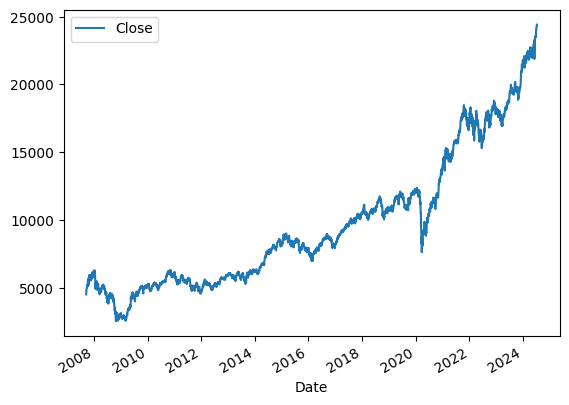

In [5]:
nifty.plot.line(y="Close", use_index=True)

In [6]:
del nifty["Dividends"]
del nifty["Stock Splits"]

In [7]:
nifty["Tomorrow"] = nifty["Close"].shift(-1)

In [8]:
nifty["Target"] = (nifty["Tomorrow"] > nifty["Close"]).astype(int)

In [9]:
nifty = nifty.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = nifty.iloc[:-100]
test = nifty.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nifty, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [ ]:
nifty

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(nifty, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
predictions